In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("white")

df = pd.read_csv("EMS_CLEAN_FULL.csv")
print(df.shape)
df.head()

(219744, 8)


,IMAGE,FIX_INDEX,FIX_DURATION,FIX_X,FIX_Y,FIX_PUPIL,SUBJECT_ID,GROUP
0,outman_054.jpg,1,205,518.5,371.3,1177,0,HEALTHY
1,outman_054.jpg,2,90,275.1,282.2,1262,0,HEALTHY
2,outman_054.jpg,3,305,600.3,271.1,1265,0,HEALTHY
3,outman_054.jpg,4,269,635.2,269.2,1326,0,HEALTHY
4,outman_054.jpg,5,318,597.3,266.0,1366,0,HEALTHY


In [2]:
def dataset_summary(df):
    print("===== DATASET SIZE SUMMARY =====\n")

    # 1) Tổng số fixation
    total_fix = len(df)
    print(f"Total fixation rows: {total_fix:,}")

    # 2) Tổng số ảnh unique
    unique_images = df["IMAGE"].nunique()
    print(f"Total unique images: {unique_images}")

    # 3) Tổng số người tham gia
    unique_subjects = df["SUBJECT_ID"].nunique()
    print(f"Total subjects: {unique_subjects}")

    # 4) Số người theo nhóm
    group_counts = df.groupby("GROUP")["SUBJECT_ID"].nunique()
    print("\nSubjects per group:")
    print(group_counts)

    # 5) Mỗi người nhìn bao nhiêu ảnh khác nhau
    images_per_subject = df.groupby("SUBJECT_ID")["IMAGE"].nunique()
    print("\nImages viewed per subject (summary):")
    print(images_per_subject.describe())

    # 6) Mỗi ảnh được bao nhiêu người nhìn
    subjects_per_image = df.groupby("IMAGE")["SUBJECT_ID"].nunique()
    print("\nSubjects per image (summary):")
    print(subjects_per_image.describe())

    # 7) Avg fixation per image
    fixations_per_image = df.groupby("IMAGE").size()
    print("\nFixations per image (summary):")
    print(fixations_per_image.describe())

    # 8) Avg fixation per subject
    fixations_per_subject = df.groupby("SUBJECT_ID").size()
    print("\nFixations per subject (summary):")
    print(fixations_per_subject.describe())

    print("\n===== END SUMMARY =====")


# Run
dataset_summary(df)

===== DATASET SIZE SUMMARY =====

Total fixation rows: 219,744
Total unique images: 100
Total subjects: 160

Subjects per group:
GROUP
HEALTHY    80
SCHIZO     80
Name: SUBJECT_ID, dtype: int64

Images viewed per subject (summary):
count    160.000000
mean      99.412500
std        3.890623
min       63.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: IMAGE, dtype: float64

Subjects per image (summary):
count    100.000000
mean     159.060000
std        0.789067
min      157.000000
25%      159.000000
50%      159.000000
75%      160.000000
max      160.000000
Name: SUBJECT_ID, dtype: float64

Fixations per image (summary):
count     100.000000
mean     2197.440000
std       171.857665
min      1794.000000
25%      2103.500000
50%      2195.500000
75%      2287.750000
max      2618.000000
dtype: float64

Fixations per subject (summary):
count     160.000000
mean     1373.400000
std       272.760825
min       452.000000
25%      1224.500000
50

In [3]:
import numpy as np
import pandas as pd

Scanpath length = tổng quãng đường mắt di chuyển giữa các fixation liên tiếp.

In [4]:
def compute_scanpath_length(df_sub):
    df_sub = df_sub.sort_values("FIX_INDEX")
    
    xs = df_sub["FIX_X"].values
    ys = df_sub["FIX_Y"].values
    
    if len(xs) < 2:
        return 0
    
    dist = np.sqrt( np.diff(xs)**2 + np.diff(ys)**2 )
    return dist.sum()

In [5]:
def extract_features(df):
    subjects = df["SUBJECT_ID"].unique()
    
    feature_rows = []

    for sub in subjects:
        df_sub = df[df["SUBJECT_ID"] == sub]

        group = df_sub["GROUP"].iloc[0]

        # --- Feature 1: Mean Fixation Duration ---
        mean_dur = df_sub["FIX_DURATION"].mean()

        # --- Feature 2: Proportion of Long Fixations (>300ms) ---
        prop_long = (df_sub["FIX_DURATION"] > 300).mean()

        # --- Feature 3: Spatial Spread of Fixation (STD of X,Y) ---
        spatial_std = np.mean([
            df_sub["FIX_X"].std(),
            df_sub["FIX_Y"].std()
        ])

        # --- Feature 4: Scanpath Length ---
        scan_len = compute_scanpath_length(df_sub)

        # --- Feature 5: Mean Pupil Size ---
        mean_pupil = df_sub["FIX_PUPIL"].mean()

        feature_rows.append([
            sub, group, mean_dur, prop_long,
            spatial_std, scan_len, mean_pupil
        ])
    
    df_feat = pd.DataFrame(feature_rows, columns=[
        "SUBJECT_ID", "GROUP",
        "MEAN_DURATION",
        "PROP_LONG_FIX",
        "SPATIAL_STD",
        "SCANPATH_LENGTH",
        "MEAN_PUPIL"
    ])
    
    return df_feat

In [9]:
df_features = extract_features(df)
print(df_features.shape)
df_features.head()

(160, 7)


,SUBJECT_ID,GROUP,MEAN_DURATION,PROP_LONG_FIX,SPATIAL_STD,SCANPATH_LENGTH,MEAN_PUPIL
0,0,HEALTHY,280.274839,0.326452,191.060243,504856.992606,1305.440645
1,1,HEALTHY,356.936327,0.453061,167.556879,357177.359981,987.677551
2,2,HEALTHY,266.431462,0.249347,173.539539,458199.538479,646.825718
3,3,HEALTHY,256.597508,0.268536,197.691763,551118.068116,963.593146
4,4,HEALTHY,349.456790,0.342593,177.359177,393936.167111,1557.318673


In [10]:
df_features.to_csv("EMS_FEATURES.csv", index=False)
print("Saved: EMS_FEATURES.csv")

Saved: EMS_FEATURES.csv


Biểu đồ EDA - Pairplot (Seaborn) 

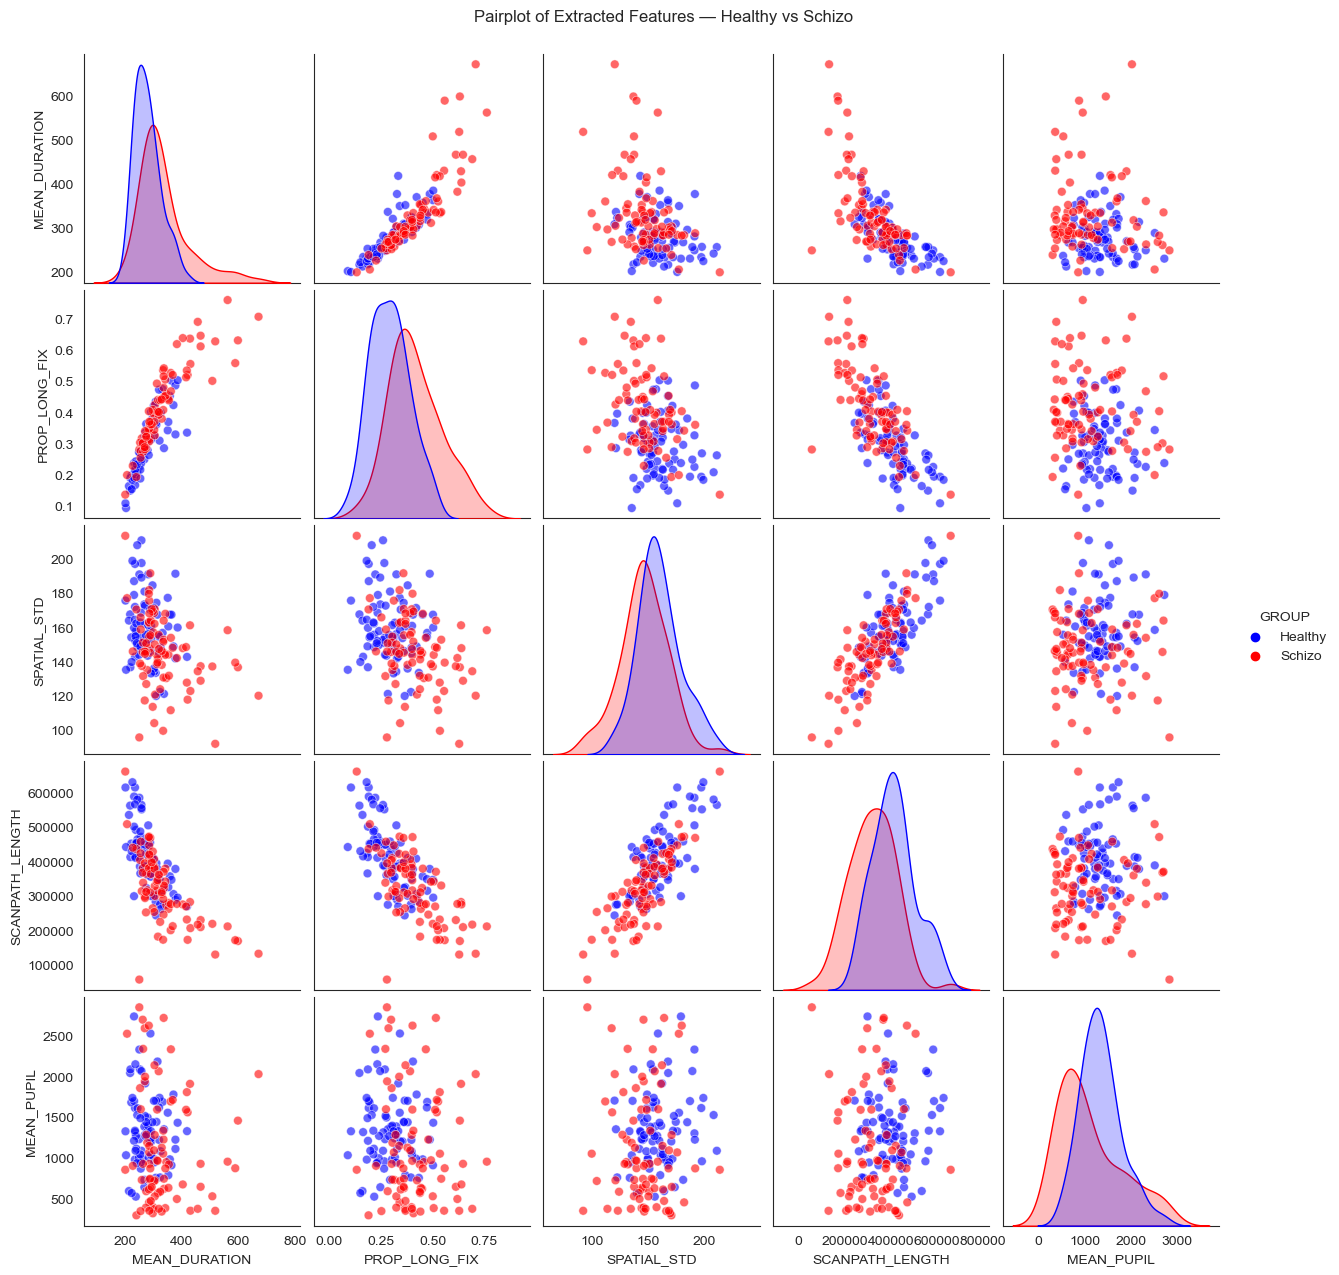

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df_features.copy()
df_plot["GROUP"] = df_plot["GROUP"].map({"HEALTHY": "Healthy", "SCHIZO": "Schizo"})

sns.pairplot(
    df_plot,
    vars=["MEAN_DURATION","PROP_LONG_FIX","SPATIAL_STD","SCANPATH_LENGTH","MEAN_PUPIL"],
    hue="GROUP",
    palette={"Healthy":"blue", "Schizo":"red"},
    diag_kind="kde",
    plot_kws={"alpha":0.6, "s":40}
)

plt.suptitle("Pairplot of Extracted Features — Healthy vs Schizo", y=1.02)
plt.show()

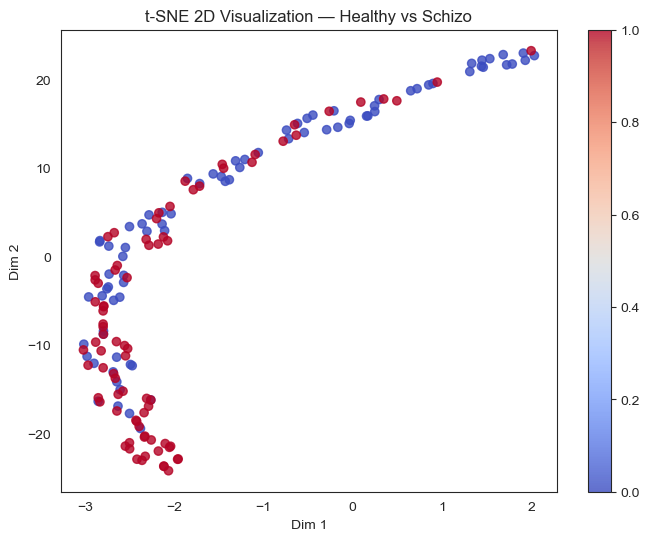

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = df_features[["MEAN_DURATION","PROP_LONG_FIX","SPATIAL_STD","SCANPATH_LENGTH","MEAN_PUPIL"]]
y = df_features["GROUP"].map({"HEALTHY":0, "SCHIZO":1})

tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap="coolwarm", alpha=0.8)
plt.title("t-SNE 2D Visualization — Healthy vs Schizo")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar()
plt.show()

In [29]:
X_pca = pca.transform(X_scaled)

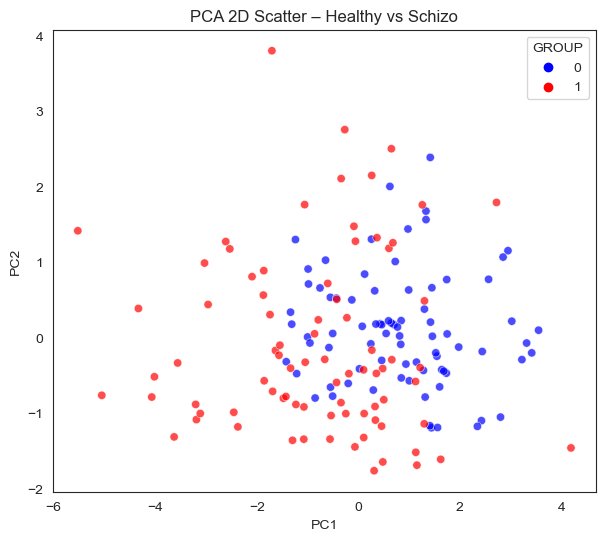

In [30]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=y,
    palette=["blue", "red"],
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Scatter – Healthy vs Schizo")
plt.show()

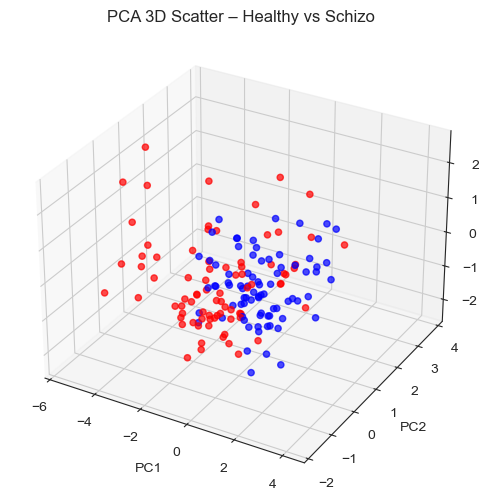

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca[:,0], X_pca[:,1], X_pca[:,2],
    c=y, cmap="bwr", alpha=0.7
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA 3D Scatter – Healthy vs Schizo")
plt.show()

FEATURE CORRELATION ANALYSIS

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

In [14]:
feature_cols = [
    "MEAN_DURATION",
    "PROP_LONG_FIX",
    "SPATIAL_STD",
    "SCANPATH_LENGTH",
    "MEAN_PUPIL"
]

X = df_features[feature_cols]
y = df_features["GROUP"].map({"HEALTHY":0, "SCHIZO":1})

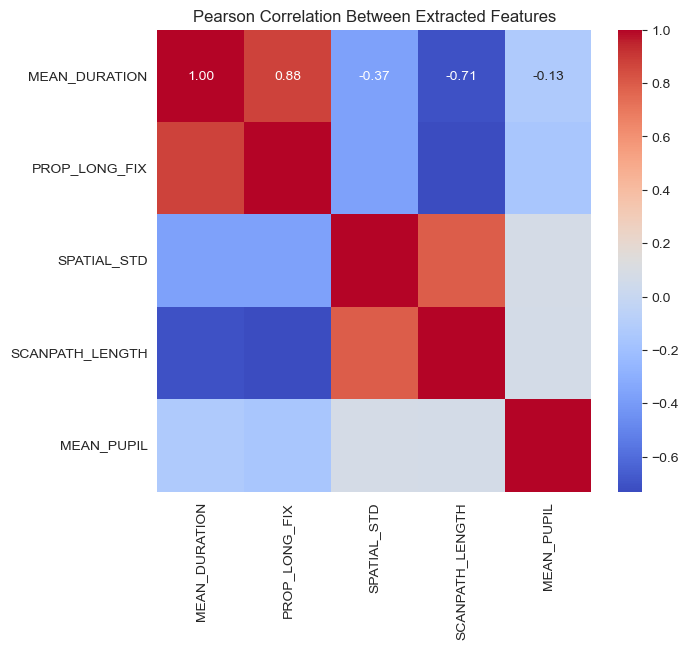

In [15]:
plt.figure(figsize=(7,6))
sns.heatmap(X.corr(method="pearson"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Between Extracted Features")
plt.show()

5 feature có redundancy cao, không đủ đa dạng → giảm khả năng phân loại.

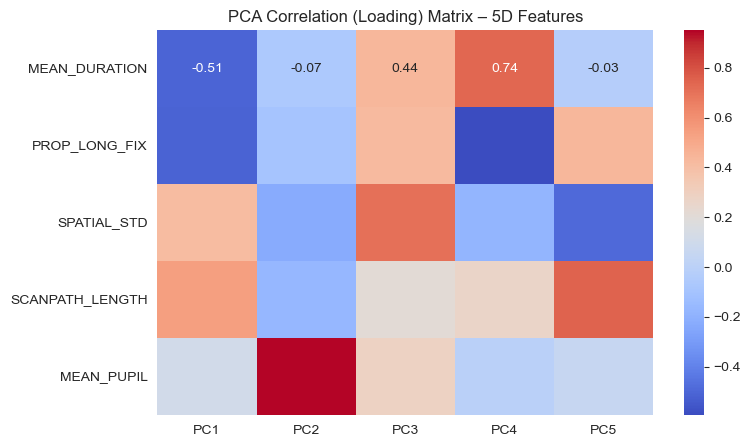

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=5)
pca.fit(X_scaled)
loadings = pca.components_.T   # shape: (5 features × 5 PCs)

plt.figure(figsize=(8,5))
sns.heatmap(
    loadings,
    annot=True,
    cmap="coolwarm",
    xticklabels=[f"PC{i+1}" for i in range(5)],
    yticklabels=feature_cols,
    fmt=".2f"
)
plt.title("PCA Correlation (Loading) Matrix – 5D Features")
plt.show()

Dữ liệu 5 chiều không chứa nhiều “thông tin hữu ích” để phân biệt class.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df_features[["MEAN_DURATION","PROP_LONG_FIX","SPATIAL_STD","SCANPATH_LENGTH","MEAN_PUPIL"]]
y = df_features["GROUP"].map({"HEALTHY":0, "SCHIZO":1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

Accuracy: 0.65625
